**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>

**Evaluation metric**
macro f1 score

> **Load the `clean data` preprocessed in `Assignment 1`, then handle it to be used with `RNNs`**

### Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Bidirectional, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report


## `Load Dataset`

In [5]:
df = pd.read_csv('cleaned_tweets.csv')

In [6]:
df.head()

,clean_tweet,tweet,label
0,father dysfunctional selfish drag kid dysfunct...,@user when a father is dysfunctional and is so...,0
1,thanks lyft credit cannot use offer wheelchair...,@user @user thanks for #lyft credit i can't us...,0
2,bihday majesty,bihday your majesty,0
3,model love take time,#model i love u take with u all the time in ...,0
4,factsguide society motivation,factsguide: society now #motivation,0


### `Preprocessing`

In [7]:
df.shape

(29131, 3)

In [8]:
df.isna().sum()

,0
clean_tweet,38
tweet,0
label,0


In [9]:
df.duplicated().sum()

0

In [10]:
df.dropna(inplace=True)
df.isna().sum()

,0
clean_tweet,0
tweet,0
label,0


In [11]:
df.shape

(29093, 3)

In [12]:
X = df['clean_tweet']
y = df['label']

## `Tokenizing & Padding`

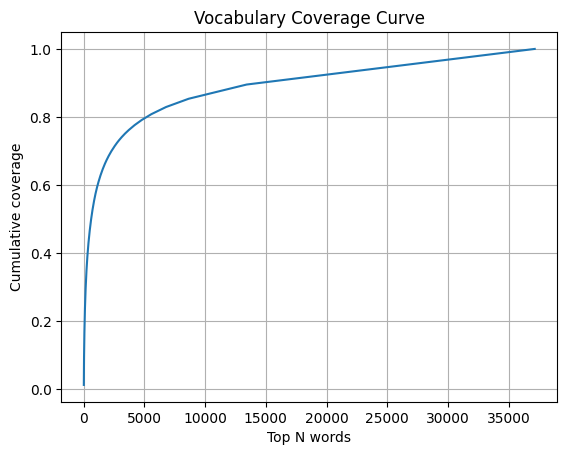

Top 30359 words cover 97.00% of total word usage


In [13]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X)

word_counts = tokenizer.word_counts
sorted_counts = sorted(word_counts.values(), reverse=True)

total = sum(sorted_counts)
cumulative = np.cumsum(sorted_counts) / total

plt.plot(cumulative)
plt.xlabel("Top N words")
plt.ylabel("Cumulative coverage")
plt.title("Vocabulary Coverage Curve")
plt.grid(True)
plt.show()

coverage = 0.97
cutoff = np.argmax(cumulative >= coverage) + 1
print(f"Top {cutoff} words cover {cumulative[cutoff-1]*100:.2f}% of total word usage")

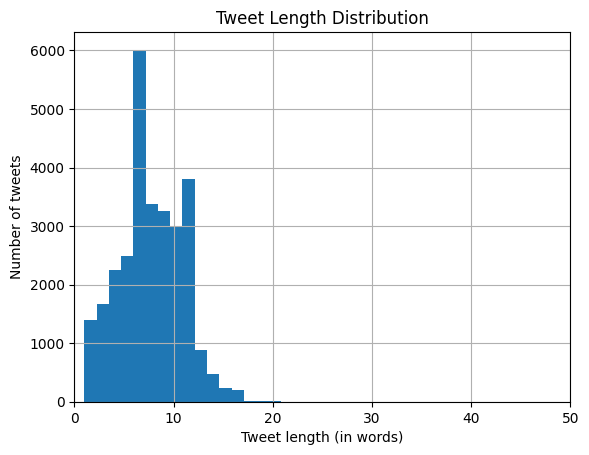

Max length: 1238
99th percentile: 15


In [14]:
sequences = tokenizer.texts_to_sequences(X)

sequences_length = [len(seq) for seq in sequences]

plt.hist(sequences_length, bins=1000)
plt.xlim(0,50)
plt.xlabel("Tweet length (in words)")
plt.ylabel("Number of tweets")
plt.title("Tweet Length Distribution")
plt.grid(True)
plt.show()

print(f"Max length: {np.max(sequences_length)}")
print(f"99th percentile: {int(np.percentile(sequences_length, 99))}")

In [15]:
MAX_NUM_WORDS = 30000
MAX_SEQUENCE_LENGTH = 30

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)

padded = pad_sequences(sequences , maxlen = MAX_SEQUENCE_LENGTH , padding='post', truncating='post')

### `Split the data`

In [62]:
x_train, x_test, y_train, y_test  = train_test_split(padded , y , test_size=0.15 , random_state=11, stratify=y)

print(x_train.shape , x_test.shape )

(24729, 30) (4364, 30)


### `Text Representation`

In [17]:
EMBEDDING_DIM = 300

In [18]:
# 1- Random Initialization (Trainable from scratch)

embedding_layer_random = Embedding(
    input_dim = MAX_NUM_WORDS,
    output_dim = EMBEDDING_DIM ,
    input_length = MAX_SEQUENCE_LENGTH ,
    trainable = True
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# 2- Vectorizing using pre-trained embedding models (Glove - Word2vec - Fasttext)

def load_embeddings(model_name, embedding_dim, word_index, vocab_size):
    embedding_model = api.load(model_name)
    embedding_matrix = np.random.normal(size=(vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        if word in embedding_model:
            embedding_matrix[i] = embedding_model[word]

    return embedding_matrix

In [20]:
word_index = tokenizer.word_index
vocab_size = min(MAX_NUM_WORDS, len(word_index) + 1)

In [21]:
glove_matrix = load_embeddings("glove-wiki-gigaword-300", EMBEDDING_DIM, word_index, vocab_size)
w2v_matrix = load_embeddings("word2vec-google-news-300", EMBEDDING_DIM, word_index, vocab_size)
fasttext_matrix = load_embeddings("fasttext-wiki-news-subwords-300", EMBEDDING_DIM, word_index, vocab_size)

[==================================================] 100.0% 376.1/376.1MB downloaded
[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


### `Computing class weights`

In [22]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.5366070653589098, 1: 7.329282750444576}


## `Modelling`

In [35]:
def build_model(model_type='LSTM', embedding_matrix=None, bidirectional=False,
                embedding_trainable=True, units=128, optimizer='adam'):
    model = Sequential()

    if embedding_matrix is not None:
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=embedding_trainable))
    else:
        model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

    if model_type == 'RNN':
        rnn_layer = SimpleRNN(units, return_sequences=False)
    elif model_type == 'GRU':
        rnn_layer = GRU(units, return_sequences=False)
    else:
        rnn_layer = LSTM(units, return_sequences=False)

    if bidirectional:
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)

    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [36]:
def train_and_evaluate(model_type='LSTM', embedding_matrix=None, bidirectional=False,
                       embedding_trainable=True, units=128, batch_size=32, epochs=10, optimizer='adam'):
    model = build_model(model_type=model_type, embedding_matrix=embedding_matrix,
                        bidirectional=bidirectional, embedding_trainable=embedding_trainable,
                        units=units, optimizer=optimizer)

    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15,
              class_weight=class_weights, callbacks=[early_stopping])

    y_pred = (model.predict(x_test) > 0.5).astype('int32')
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"\nModel: {model_type}, Bidirectional: {bidirectional}, Units: {units}, Optimizer: {optimizer}, F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return f1

## `Evaluation`

### `RNN`

In [37]:
print("\n--- GloVe ---")
train_and_evaluate(model_type='RNN', embedding_matrix=glove_matrix, bidirectional=False, units=32, optimizer='adam')

print("\n--- GloVe ---")
train_and_evaluate(model_type='RNN', embedding_matrix=glove_matrix, bidirectional=False, units=32, optimizer='RMSprop')

print("\n--- Word2Vec ---")
train_and_evaluate(model_type='RNN', embedding_matrix=w2v_matrix, bidirectional=False, units=64, optimizer='adam')

print("\n--- FastText ---")
train_and_evaluate(model_type='RNN', embedding_matrix=fasttext_matrix, bidirectional=False, units=128, optimizer='adam')

print("\n--- GloVe ---")
train_and_evaluate(model_type='RNN', embedding_matrix=glove_matrix, bidirectional=True, units=32, optimizer='adam')

print("\n--- GloVe ---")
train_and_evaluate(model_type='RNN', embedding_matrix=glove_matrix, bidirectional=True, units=32, optimizer='RMSprop')

print("\n--- Word2Vec ---")
train_and_evaluate(model_type='RNN', embedding_matrix=w2v_matrix, bidirectional=True, units=64, optimizer='adam')

print("\n--- FastText ---")
train_and_evaluate(model_type='RNN', embedding_matrix=fasttext_matrix, bidirectional=True, units=128, optimizer='adam')


--- GloVe ---


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - accuracy: 0.5231 - loss: 0.7090 - val_accuracy: 0.9245 - val_loss: 0.6796
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5245 - loss: 0.6968 - val_accuracy: 0.9245 - val_loss: 0.6577
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6402 - loss: 0.6847 - val_accuracy: 0.0755 - val_loss: 0.7284
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3724 - loss: 0.6977 - val_accuracy: 0.0755 - val_loss: 0.6980
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5956 - loss: 0.6741 - val_accuracy: 0.0755 - val_loss: 0.7001
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Model: RNN, Bidirectional: False, Units: 32, Optimizer: adam, F1 Score: 0.4823

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4066
           1       0.00      0.00      0.00       298

    accuracy                           0.93     

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.5561 - loss: 0.7291 - val_accuracy: 0.0755 - val_loss: 0.7266
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5881 - loss: 0.7001 - val_accuracy: 0.0755 - val_loss: 0.8507
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5419 - loss: 0.7118 - val_accuracy: 0.0755 - val_loss: 0.8699
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5678 - loss: 0.7078 - val_accuracy: 0.0755 - val_loss: 0.7412
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Model: RNN, Bidirectional: False, Units: 32, Optimizer: RMSprop, F1 Score: 0.0642

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4066
           1       0.07      1.00      0.13       298

    accuracy                           0.07      4364
   macro avg       0.53      0.50      0.06      4364
weighted avg       0.94      0.07      0.01      4364


--- Word2V

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5175 - loss: 0.7171 - val_accuracy: 0.0755 - val_loss: 0.7096
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5227 - loss: 0.6868 - val_accuracy: 0.9245 - val_loss: 0.6751
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6334 - loss: 0.6740 - val_accuracy: 0.0755 - val_loss: 0.6974
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6326 - loss: 0.6678 - val_accuracy: 0.0755 - val_loss: 0.7016
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3869 - loss: 0.6921 - val_accuracy: 0.0755 - val_loss: 0.6992
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: RNN, Bidirectional: False, Units: 64, Optimizer: adam, F1 Score: 0.4823

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4066
           1       0.00      0.00      0.00       298

    accuracy                           0.93      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5323 - loss: 0.7390 - val_accuracy: 0.9245 - val_loss: 0.6729
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6486 - loss: 0.6823 - val_accuracy: 0.0755 - val_loss: 0.7616
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4813 - loss: 0.6900 - val_accuracy: 0.9245 - val_loss: 0.6717
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5564 - loss: 0.6992 - val_accuracy: 0.9245 - val_loss: 0.6926
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6620 - loss: 0.6901 - val_accuracy: 0.0755 - val_loss: 0.6951
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6620 - loss: 0.6843 - val_accuracy: 0.0755 - val_loss: 0.6969
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: RNN, Bidirectional: False, Units: 128, Optimizer: adam, F1 Score: 0.4823

Classification Report:
              precision    recall  f1-score   support

           0       0.93     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7031 - loss: 0.5609 - val_accuracy: 0.8488 - val_loss: 0.3756
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9057 - loss: 0.2419 - val_accuracy: 0.9137 - val_loss: 0.2252
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9597 - loss: 0.1110 - val_accuracy: 0.8965 - val_loss: 0.3129
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9747 - loss: 0.0653 - val_accuracy: 0.9183 - val_loss: 0.2870
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9831 - loss: 0.0434 - val_accuracy: 0.8962 - val_loss: 0.3652
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Model: RNN, Bidirectional: True, Units: 32, Optimizer: adam, F1 Score: 0.7368

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      4066
           1       0.40      0.77      0.53       298

    accuracy                           0.91

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.5758 - loss: 0.7119 - val_accuracy: 0.0755 - val_loss: 0.7323
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5895 - loss: 0.7028 - val_accuracy: 0.0755 - val_loss: 0.7371
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6374 - loss: 0.6883 - val_accuracy: 0.0755 - val_loss: 0.7714
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5805 - loss: 0.7032 - val_accuracy: 0.0755 - val_loss: 0.7628
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Model: RNN, Bidirectional: False, Units: 32, Optimizer: RMSprop, F1 Score: 0.0642

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4066
           1       0.07      1.00      0.13       298

    accuracy                           0.07      4364
   macro avg       0.53      0.50      0.06      4364
weighted avg       0.94      0.07      0.01      4364


--- Word2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7148 - loss: 0.5654 - val_accuracy: 0.8299 - val_loss: 0.3759
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9129 - loss: 0.2134 - val_accuracy: 0.8973 - val_loss: 0.2541
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9629 - loss: 0.0891 - val_accuracy: 0.9116 - val_loss: 0.2655
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9810 - loss: 0.0502 - val_accuracy: 0.9040 - val_loss: 0.3230
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9863 - loss: 0.0328 - val_accuracy: 0.8995 - val_loss: 0.4386
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

Model: RNN, Bidirectional: True, Units: 64, Optimizer: adam, F1 Score: 0.7331

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4066
           1       0.39      0.80      0.52       298

    accuracy                           0.9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6455 - loss: 0.6497 - val_accuracy: 0.7464 - val_loss: 0.4950
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9020 - loss: 0.2435 - val_accuracy: 0.8580 - val_loss: 0.3402
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9577 - loss: 0.1271 - val_accuracy: 0.9008 - val_loss: 0.2843
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9790 - loss: 0.0536 - val_accuracy: 0.9030 - val_loss: 0.3032
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9789 - loss: 0.0486 - val_accuracy: 0.8919 - val_loss: 0.2993
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9870 - loss: 0.0340 - val_accuracy: 0.9073 - val_loss: 0.4158
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

Model: RNN, Bidirectional: True, Units: 128, Optimizer: adam, F1 Score: 0.7331

Classification Report:
              precision    recall  f1-score   support

           0       0.9

0.7330635064633766

### `LSTM`

In [38]:
print("\n--- GloVe ---")
train_and_evaluate(model_type='LSTM', embedding_matrix=glove_matrix, bidirectional=False, units=32, optimizer='adam')

print("\n--- GloVe ---")
train_and_evaluate(model_type='LSTM', embedding_matrix=glove_matrix, bidirectional=False, units=32, optimizer='RMSprop')

print("\n--- Word2Vec ---")
train_and_evaluate(model_type='LSTM', embedding_matrix=w2v_matrix, bidirectional=False, units=64, optimizer='adam')

print("\n--- FastText ---")
train_and_evaluate(model_type='LSTM', embedding_matrix=fasttext_matrix, bidirectional=False, units=128, optimizer='adam')

print("\n--- GloVe ---")
train_and_evaluate(model_type='LSTM', embedding_matrix=glove_matrix, bidirectional=True, units=32, optimizer='adam')

print("\n--- GloVe ---")
train_and_evaluate(model_type='LSTM', embedding_matrix=glove_matrix, bidirectional=True, units=32, optimizer='RMSprop')

print("\n--- Word2Vec ---")
train_and_evaluate(model_type='LSTM', embedding_matrix=w2v_matrix, bidirectional=True, units=64, optimizer='adam')

print("\n--- FastText ---")
train_and_evaluate(model_type='LSTM', embedding_matrix=fasttext_matrix, bidirectional=True, units=128, optimizer='adam')


--- GloVe ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5637 - loss: 0.6484 - val_accuracy: 0.8598 - val_loss: 0.3873
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8453 - loss: 0.3449 - val_accuracy: 0.8682 - val_loss: 0.3100
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9133 - loss: 0.2257 - val_accuracy: 0.9175 - val_loss: 0.2459
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9733 - loss: 0.1022 - val_accuracy: 0.9102 - val_loss: 0.3464
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9858 - loss: 0.0496 - val_accuracy: 0.9224 - val_loss: 0.3789
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9907 - loss: 0.0306 - val_accuracy: 0.9213 - val_loss: 0.3806
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Model: LSTM, Bidirectional: False, Units: 32, Optimizer: adam, F1 Score: 0.7649

Classification Report:
              precision    recall  f1-score   support

           0       0.9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5747 - loss: 0.6966 - val_accuracy: 0.9245 - val_loss: 0.6321
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7943 - loss: 0.6796 - val_accuracy: 0.9245 - val_loss: 0.6830
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6821 - loss: 0.6958 - val_accuracy: 0.0755 - val_loss: 0.7244
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6579 - loss: 0.6826 - val_accuracy: 0.9245 - val_loss: 0.6813
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Model: LSTM, Bidirectional: False, Units: 32, Optimizer: RMSprop, F1 Score: 0.4823

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4066
           1       0.00      0.00      0.00       298

    accuracy                           0.93      4364
   macro avg       0.47      0.50      0.48      4364
weighted avg       0.87      0.93      0.90      4364


--- W

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6593 - loss: 0.6435 - val_accuracy: 0.8933 - val_loss: 0.3053
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8424 - loss: 0.3651 - val_accuracy: 0.9302 - val_loss: 0.1843
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9458 - loss: 0.1786 - val_accuracy: 0.8811 - val_loss: 0.3888
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9816 - loss: 0.0673 - val_accuracy: 0.9224 - val_loss: 0.2976
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9843 - loss: 0.0480 - val_accuracy: 0.8838 - val_loss: 0.4621
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Model: LSTM, Bidirectional: False, Units: 64, Optimizer: adam, F1 Score: 0.7747

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4066
           1       0.48      0.75      0.59       298

    accuracy                           0.9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5451 - loss: 0.6989 - val_accuracy: 0.9245 - val_loss: 0.6605
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4522 - loss: 0.6967 - val_accuracy: 0.9245 - val_loss: 0.6644
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5461 - loss: 0.6962 - val_accuracy: 0.0755 - val_loss: 0.6980
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5693 - loss: 0.6936 - val_accuracy: 0.0755 - val_loss: 0.7004
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Model: LSTM, Bidirectional: False, Units: 128, Optimizer: adam, F1 Score: 0.4823

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4066
           1       0.00      0.00      0.00       298

    accuracy                           0.93      4364
   macro avg       0.47      0.50      0.48      4364
weighted avg       0.87      0.93      0.90      4364


--- Glo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.7463 - loss: 0.5077 - val_accuracy: 0.8426 - val_loss: 0.4028
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9281 - loss: 0.1978 - val_accuracy: 0.9043 - val_loss: 0.2431
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9716 - loss: 0.0712 - val_accuracy: 0.9251 - val_loss: 0.2276
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9894 - loss: 0.0275 - val_accuracy: 0.9296 - val_loss: 0.2707
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9946 - loss: 0.0142 - val_accuracy: 0.9191 - val_loss: 0.3171
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9962 - loss: 0.0093 - val_accuracy: 0.9197 - val_loss: 0.3929
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: LSTM, Bidirectional: True, Units: 32, Optimizer: adam, F1 Score: 0.7771

Classification Report:
              precision    recall  f1-score   support

           0       0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7683 - loss: 0.5136 - val_accuracy: 0.8790 - val_loss: 0.2983
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8915 - loss: 0.2859 - val_accuracy: 0.8677 - val_loss: 0.3142
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9148 - loss: 0.2134 - val_accuracy: 0.9183 - val_loss: 0.2064
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9424 - loss: 0.1557 - val_accuracy: 0.9129 - val_loss: 0.2297
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9600 - loss: 0.1156 - val_accuracy: 0.9105 - val_loss: 0.2785
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9765 - loss: 0.0751 - val_accuracy: 0.9167 - val_loss: 0.2733
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: LSTM, Bidirectional: True, Units: 32, Optimizer: RMSprop, F1 Score: 0.7583

Classification Report:
              precision    recall  f1-score   support

           0       0.9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.7161 - loss: 0.5231 - val_accuracy: 0.8547 - val_loss: 0.3454
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9385 - loss: 0.1531 - val_accuracy: 0.9067 - val_loss: 0.2423
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9804 - loss: 0.0525 - val_accuracy: 0.8868 - val_loss: 0.3423
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9903 - loss: 0.0272 - val_accuracy: 0.9170 - val_loss: 0.2504
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9931 - loss: 0.0185 - val_accuracy: 0.9054 - val_loss: 0.4414
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: LSTM, Bidirectional: True, Units: 64, Optimizer: adam, F1 Score: 0.7378

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.94      4066
           1       0.39      0.82      0.53       298

    accuracy                           0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.6700 - loss: 0.5764 - val_accuracy: 0.7774 - val_loss: 0.4795
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9284 - loss: 0.1727 - val_accuracy: 0.9035 - val_loss: 0.2380
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9822 - loss: 0.0558 - val_accuracy: 0.8906 - val_loss: 0.3232
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9902 - loss: 0.0269 - val_accuracy: 0.9086 - val_loss: 0.3351
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9931 - loss: 0.0164 - val_accuracy: 0.9140 - val_loss: 0.3778
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: LSTM, Bidirectional: True, Units: 128, Optimizer: adam, F1 Score: 0.7322

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4066
           1       0.39      0.80      0.52       298

    accuracy                           0

0.7321795697934885

### `GRU`

In [39]:
print("\n--- GloVe ---")
train_and_evaluate(model_type='GRU', embedding_matrix=glove_matrix, bidirectional=False, units=32, optimizer='adam')

print("\n--- GloVe ---")
train_and_evaluate(model_type='GRU', embedding_matrix=glove_matrix, bidirectional=False, units=32, optimizer='RMSprop')

print("\n--- Word2Vec ---")
train_and_evaluate(model_type='GRU', embedding_matrix=w2v_matrix, bidirectional=False, units=64, optimizer='adam')

print("\n--- FastText ---")
train_and_evaluate(model_type='GRU', embedding_matrix=fasttext_matrix, bidirectional=False, units=128, optimizer='adam')

print("\n--- GloVe ---")
train_and_evaluate(model_type='GRU', embedding_matrix=glove_matrix, bidirectional=True, units=32, optimizer='adam')

print("\n--- GloVe ---")
train_and_evaluate(model_type='GRU', embedding_matrix=glove_matrix, bidirectional=True, units=32, optimizer='RMSprop')

print("\n--- Word2Vec ---")
train_and_evaluate(model_type='GRU', embedding_matrix=w2v_matrix, bidirectional=True, units=64, optimizer='adam')

print("\n--- FastText ---")
train_and_evaluate(model_type='GRU', embedding_matrix=fasttext_matrix, bidirectional=True, units=128, optimizer='adam')


--- GloVe ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6587 - loss: 0.6000 - val_accuracy: 0.8989 - val_loss: 0.2726
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9298 - loss: 0.2118 - val_accuracy: 0.9016 - val_loss: 0.2821
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9713 - loss: 0.0918 - val_accuracy: 0.9049 - val_loss: 0.2788
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9839 - loss: 0.0478 - val_accuracy: 0.9210 - val_loss: 0.2835
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Model: GRU, Bidirectional: False, Units: 32, Optimizer: adam, F1 Score: 0.7272

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      4066
           1       0.37      0.85      0.52       298

    accuracy                           0.89      4364
   macro avg       0.68      0.87      0.73      4364
weighted avg       0.95      0.89      0.91      4364


--- GloV

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6279 - loss: 0.6573 - val_accuracy: 0.8135 - val_loss: 0.4467
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8626 - loss: 0.3599 - val_accuracy: 0.8916 - val_loss: 0.2641
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9047 - loss: 0.2585 - val_accuracy: 0.8852 - val_loss: 0.2715
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9242 - loss: 0.2098 - val_accuracy: 0.8951 - val_loss: 0.2755
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9394 - loss: 0.1718 - val_accuracy: 0.9280 - val_loss: 0.2269
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9564 - loss: 0.1267 - val_accuracy: 0.9075 - val_loss: 0.2788
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9726 - loss: 0.0869 - val_accuracy: 0.9127 - val_loss: 0.3216
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9774 - loss: 0.0758 - val_ac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6278 - loss: 0.6127 - val_accuracy: 0.8757 - val_loss: 0.3176
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9304 - loss: 0.2032 - val_accuracy: 0.9167 - val_loss: 0.2318
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9737 - loss: 0.0797 - val_accuracy: 0.9175 - val_loss: 0.2492
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9873 - loss: 0.0397 - val_accuracy: 0.9173 - val_loss: 0.3316
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9929 - loss: 0.0182 - val_accuracy: 0.9315 - val_loss: 0.3267
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Model: GRU, Bidirectional: False, Units: 64, Optimizer: adam, F1 Score: 0.7521

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4066
           1       0.42      0.80      0.55       298

    accuracy                           0.91

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6198 - loss: 0.6360 - val_accuracy: 0.7927 - val_loss: 0.4746
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9241 - loss: 0.1993 - val_accuracy: 0.9340 - val_loss: 0.1809
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9789 - loss: 0.0754 - val_accuracy: 0.8388 - val_loss: 0.5450
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9816 - loss: 0.0495 - val_accuracy: 0.9299 - val_loss: 0.3420
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9924 - loss: 0.0237 - val_accuracy: 0.9043 - val_loss: 0.4384
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Model: GRU, Bidirectional: False, Units: 128, Optimizer: adam, F1 Score: 0.7980

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4066
           1       0.56      0.72      0.63       298

    accuracy                           0.9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.7475 - loss: 0.5163 - val_accuracy: 0.8784 - val_loss: 0.3212
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9318 - loss: 0.1811 - val_accuracy: 0.9253 - val_loss: 0.1981
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9762 - loss: 0.0659 - val_accuracy: 0.9232 - val_loss: 0.2664
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9899 - loss: 0.0268 - val_accuracy: 0.9270 - val_loss: 0.2634
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9938 - loss: 0.0160 - val_accuracy: 0.9299 - val_loss: 0.3467
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: GRU, Bidirectional: True, Units: 32, Optimizer: adam, F1 Score: 0.7763

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4066
           1       0.47      0.83      0.59       298

    accuracy                           0.9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7457 - loss: 0.5286 - val_accuracy: 0.8949 - val_loss: 0.2615
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8795 - loss: 0.3124 - val_accuracy: 0.8809 - val_loss: 0.2715
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9116 - loss: 0.2396 - val_accuracy: 0.9132 - val_loss: 0.2267
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9322 - loss: 0.1763 - val_accuracy: 0.9081 - val_loss: 0.2526
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9537 - loss: 0.1359 - val_accuracy: 0.8871 - val_loss: 0.2815
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9680 - loss: 0.1017 - val_accuracy: 0.9372 - val_loss: 0.2362
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: GRU, Bidirectional: True, Units: 32, Optimizer: RMSprop, F1 Score: 0.7625

Classification Report:
              precision    recall  f1-score   support

           0       0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.7150 - loss: 0.5409 - val_accuracy: 0.7951 - val_loss: 0.4289
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9315 - loss: 0.1530 - val_accuracy: 0.9049 - val_loss: 0.2717
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9771 - loss: 0.0613 - val_accuracy: 0.9146 - val_loss: 0.2756
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9915 - loss: 0.0248 - val_accuracy: 0.9059 - val_loss: 0.3776
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9950 - loss: 0.0119 - val_accuracy: 0.9237 - val_loss: 0.3737
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: GRU, Bidirectional: True, Units: 64, Optimizer: adam, F1 Score: 0.7544

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      4066
           1       0.42      0.85      0.56       298

    accuracy                           0.9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.6847 - loss: 0.5726 - val_accuracy: 0.8925 - val_loss: 0.2819
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9445 - loss: 0.1542 - val_accuracy: 0.9218 - val_loss: 0.2128
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9792 - loss: 0.0613 - val_accuracy: 0.9332 - val_loss: 0.2394
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9915 - loss: 0.0250 - val_accuracy: 0.9008 - val_loss: 0.3594
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9945 - loss: 0.0132 - val_accuracy: 0.9084 - val_loss: 0.4072
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: GRU, Bidirectional: True, Units: 128, Optimizer: adam, F1 Score: 0.7608

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      4066
           1       0.45      0.77      0.57       298

    accuracy                           0.

0.7607880306938055

## `Results & Conclusion`

 > **`Best Model` --> Model: `GRU`, Bidirectional: `False`, Units: `128`, Optimizer: `adam`, F1 Score: `0.7980` Using pre-trained `Fasttext` with:**

 > **Accuracy : `0.94`**

 > **F1-Score : `0.80`**


In [63]:
best_model = Sequential()

best_model.add(Embedding(input_dim=vocab_size, output_dim=fasttext_matrix.shape[1],
                            weights=[fasttext_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True))
best_model.add(GRU(128, return_sequences=False))
best_model.add(Dropout(0.2))
best_model.add(Dense(64, activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(1, activation='sigmoid'))

best_model.summary()

best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_48 (Embedding)        │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 9,000,000 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

best_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.15,
          class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5924 - loss: 0.6637 - val_accuracy: 0.8970 - val_loss: 0.2729
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9236 - loss: 0.2337 - val_accuracy: 0.8916 - val_loss: 0.2737
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9717 - loss: 0.0953 - val_accuracy: 0.9202 - val_loss: 0.2448
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9881 - loss: 0.0340 - val_accuracy: 0.9307 - val_loss: 0.2775
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9955 - loss: 0.0130 - val_accuracy: 0.9016 - val_loss: 0.4805
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9968 - loss: 0.0093 - val_accuracy: 0.9105 - val_loss: 0.4233


In [65]:
y_pred = (best_model.predict(x_test) > 0.5).astype('int32')

train_accuracy = best_model.evaluate(x_train, y_train)[1]
test_accuracy =best_model.evaluate(x_test, y_test)[1]

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9881 - loss: 0.0402
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9224 - loss: 0.2597


In [66]:
print('\nTrain Accuracy : ', train_accuracy)
print('Test Accuracy : ', test_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='macro')
print("\nMacro F1 Score : ", f1)


Train Accuracy :  0.9784867763519287
Test Accuracy :  0.9172777533531189

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      4066
           1       0.44      0.73      0.55       298

    accuracy                           0.92      4364
   macro avg       0.71      0.83      0.75      4364
weighted avg       0.94      0.92      0.93      4364


Macro F1 Score :  0.7507669268520032


#### Done!